https://towardsdatascience.com/pycaret-skorch-build-pytorch-neural-networks-using-minimal-code-57079e197f33

In [24]:
import pandas as pd 
import numpy as np
import torch

In [25]:
from pycaret.datasets import get_data
data = get_data('electrical_grid')

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable


In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['stabf'] = le.fit_transform(data['stabf'])

In [27]:
data['stabf'] = torch.from_numpy(data['stabf'].values).view(1, -1)[0].type(torch.LongTensor)

In [28]:
data.dtypes

tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stabf      int64
dtype: object

In [29]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, num_inputs=12, num_units_d1=200, num_units_d2=100):
        super(Net, self).__init__()
        self.dense0 = nn.Linear(num_inputs, num_units_d1)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units_d1, num_units_d2)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(num_units_d2, 2)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X

In [30]:
from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    module=Net,
    max_epochs=30,
    lr=0.1,
    batch_size=32,
    train_split=None
)

In [31]:
from skorch.helper import DataFrameTransformer
from sklearn.pipeline import Pipeline
nn_pipe = Pipeline(
    [
        ("transform", DataFrameTransformer()),
        ("net", net),
    ]
)

In [32]:
from pycaret.classification import *
target = "stabf"
clf1 = setup(data = data, 
            target = target,#.torch.long(),
            #loss = criterion(output, target.long()),
            train_size = 0.8,
            fold = 5,
            session_id = 123,
            log_experiment = True, 
            experiment_name = 'electrical_grid_1', 
            silent = True)

,Description,Value
0,session_id,123
1,Target,stabf
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(10000, 13)"
5,Missing Values,False
6,Numeric Features,12
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [33]:
rf_model = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9244,0.9796,0.9667,0.9189,0.9422,0.8331,0.8353
1,0.9275,0.9793,0.9549,0.9330,0.9438,0.8417,0.8422
2,0.9225,0.9810,0.9608,0.9211,0.9406,0.8294,0.8309
3,0.9081,0.9738,0.9461,0.9130,0.9293,0.7983,0.7993
4,0.9044,0.9738,0.9471,0.9071,0.9267,0.7894,0.7909
Mean,0.9174,0.9775,0.9551,0.9186,0.9365,0.8184,0.8197
SD,0.0093,0.0031,0.0079,0.0087,0.0071,0.0206,0.0206


In [34]:
skorch_model = create_model(nn_pipe)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8744,0.9602,0.9598,0.8595,0.9069,0.7156,0.7260
1,0.8431,0.9461,0.9657,0.8201,0.8870,0.6361,0.6592
2,0.8631,0.9319,0.9324,0.8639,0.8968,0.6944,0.6989
3,0.8450,0.9225,0.8972,0.8650,0.8808,0.6596,0.6605
4,0.7862,0.9365,0.9794,0.7570,0.8540,0.4787,0.5383
Mean,0.8424,0.9394,0.9469,0.8331,0.8851,0.6369,0.6566
SD,0.0304,0.0129,0.0292,0.0415,0.0179,0.0837,0.0642


In [35]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9416,0.9888,0.9649,0.9447,0.9547,0.8726,0.8731,1.5720
lightgbm,Light Gradient Boosting Machine,0.9396,0.9873,0.9612,0.9451,0.9531,0.8685,0.8687,0.5580
et,Extra Trees Classifier,0.9210,0.9829,0.9743,0.9085,0.9402,0.8241,0.8286,0.2980
gbc,Gradient Boosting Classifier,0.9199,0.9769,0.9626,0.9161,0.9387,0.8231,0.8254,0.6220
rf,Random Forest Classifier,0.9174,0.9775,0.9551,0.9186,0.9365,0.8184,0.8197,0.5420
ada,Ada Boost Classifier,0.8450,0.9283,0.8987,0.8639,0.8809,0.6592,0.6604,0.2020
dt,Decision Tree Classifier,0.8389,0.8252,0.8748,0.8730,0.8738,0.6510,0.6512,0.0540
nb,Naive Bayes,0.8305,0.9161,0.9236,0.8300,0.8742,0.6166,0.6251,0.0160
ridge,Ridge Classifier,0.8132,0.0000,0.8787,0.8368,0.8572,0.5879,0.5896,0.0140
lr,Logistic Regression,0.8128,0.8906,0.8771,0.8372,0.8566,0.5872,0.5887,0.0420


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)

In [36]:
best_model = compare_models(include=[skorch_model, rf_model], sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
1,Random Forest Classifier,0.9174,0.9775,0.9551,0.9186,0.9365,0.8184,0.8197,0.5440
0,NeuralNetClassifier,0.8444,0.9398,0.9516,0.8314,0.8868,0.6414,0.6596,7.4060


In [37]:
import torch.optim as optim
custom_grid = {
	'net__max_epochs':[5, 10, 20, 50, 100, 200, 400],
	'net__batch_size':[16, 32, 64, 128],
	'net__lr': [0.001, 0.01, 0.05, 0.1],
	'net__module__num_units_d1': [5, 10, 50, 100, 150],
	'net__module__num_units_d2': [5, 10, 50, 100, 150],
	'net__optimizer': [optim.Adam, optim.SGD, optim.RMSprop, optim.Adamax]
	}

In [38]:
skorch_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transform', 'net', 'transform__float_dtype', 'transform__int_dtype', 'transform__treat_int_as_categorical', 'net__module', 'net__criterion', 'net__optimizer', 'net__lr', 'net__max_epochs', 'net__batch_size', 'net__iterator_train', 'net__iterator_valid', 'net__dataset', 'net__train_split', 'net__callbacks', 'net__predict_nonlinearity', 'net__warm_start', 'net__verbose', 'net__device', 'net__classes', 'net__callbacks__epoch_timer', 'net__callbacks__train_loss', 'net__callbacks__train_loss__name', 'net__callbacks__train_loss__lower_is_better', 'net__callbacks__train_loss__on_train', 'net__callbacks__valid_loss', 'net__callbacks__valid_loss__name', 'net__callbacks__valid_loss__lower_is_better', 'net__callbacks__valid_loss__on_train', 'net__callbacks__valid_acc', 'net__callbacks__valid_acc__scoring', 'net__callbacks__valid_acc__lower_is_better', 'net__callbacks__valid_acc__on_train', 'net__callbacks__valid_acc__name', 'net__callbacks__valid_acc__tar

In [39]:
tuned_skorch_model = tune_model(skorch_model, custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9319,0.9821,0.9245,0.9672,0.9454,0.8550,0.8566
1,0.9406,0.9864,0.9598,0.9477,0.9537,0.8709,0.8710
2,0.9325,0.9827,0.9412,0.9524,0.9468,0.8545,0.8546
3,0.9044,0.9803,0.8717,0.9759,0.9208,0.8011,0.8092
4,0.8438,0.9625,0.9843,0.8111,0.8894,0.6317,0.6670
Mean,0.9106,0.9788,0.9363,0.9309,0.9312,0.8026,0.8117
SD,0.0356,0.0084,0.0379,0.0607,0.0237,0.0887,0.0753


In [40]:
best_model = compare_models(include=[tuned_skorch_model, skorch_model, rf_model], sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,NeuralNetClassifier,0.9105,0.9798,0.9289,0.9356,0.9302,0.8046,0.8119,27.9880
2,Random Forest Classifier,0.9174,0.9775,0.9551,0.9186,0.9365,0.8184,0.8197,0.5780
1,NeuralNetClassifier,0.8406,0.9398,0.9571,0.8252,0.8853,0.6290,0.6525,3.7480


In [41]:
best_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('transform',
                 DataFrameTransformer(float_dtype=<class 'numpy.float32'>,
                                      int_dtype=<class 'numpy.int64'>,
                                      treat_int_as_categorical=False)),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (dense0): Linear(in_features=12, out_features=150, bias=True)
    (nonlin): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=150, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=2, bias=True)
    (softmax): Softmax(dim=-1)
  ),
))],
         verbose=False)>

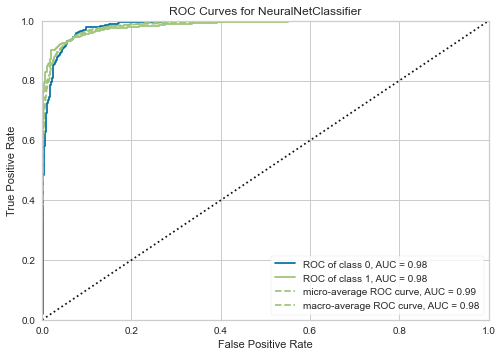

In [42]:
plot_model(best_model, plot="auc")

In [43]:
tuned_skorch_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('transform',
                 DataFrameTransformer(float_dtype=<class 'numpy.float32'>,
                                      int_dtype=<class 'numpy.int64'>,
                                      treat_int_as_categorical=False)),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (dense0): Linear(in_features=12, out_features=150, bias=True)
    (nonlin): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=150, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=2, bias=True)
    (softmax): Softmax(dim=-1)
  ),
))],
         verbose=False)>

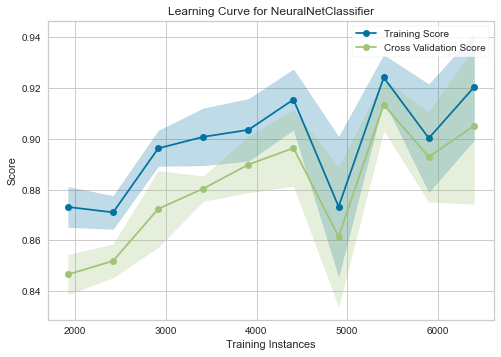

In [44]:
plot_model(best_model, 'learning')